In [1]:
! pip install tqdm -q
! pip install -U matplotlib -q
! pip install scikit-image -q
! pip install opencv-python -q


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [147]:
import torch
import os
from torch import nn
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.datasets import ImageFolder
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import cv2
import skimage
from torch.utils.data import DataLoader
from torchvision import transforms
from utils import *
from model import ColorizationCNN
%reload_ext autoreload
%autoreload 2

In [148]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [151]:
# Define hyperparameters
batch_size = 4
learning_rate = .02
num_epochs = 20

num_channels_in = 1
num_channels_out = 2
im_size = 256

In [167]:
# Load images
import os
foldername = "images"
testername = "images_test"
if os.path.exists(foldername+"/.ipynb_checkpoints"):
    os.rmdir(foldername+"/.ipynb_checkpoints")
if os.path.exists(testername+"/.ipynb_checkpoints"):
    os.rmdir(testername+"/.ipynb_checkpoints")
! rm -rf images/.ipynb_checkpoints
def getDataLoader(img_root, batchsize):
    imgfolder = ImageFolder(root=img_root, transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize((256,256), antialias=True),
    ]))
    img_dataloader = DataLoader(imgfolder, batch_size = batchsize)
    return img_dataloader

img_train_loader = getDataLoader(foldername, batch_size)
img_test_loader = getDataLoader(testername, 1)
full_folder = getDataLoader(foldername, 1)

In [153]:
def get_single_test_img(i = 0):
    return get_test_batch()[i]
def get_next_batch(dataloader):
    x, _ = next(iter(dataloader))
    return x
#Print first image of trainloader
#plt.imshow(get_single_test_img(2).permute(1,2,0))

In [154]:
# Load VGG19
vgg = torchvision.models.vgg19(pretrained=True).to(device).eval()

In [ ]:
allimages = get_next_batch(full_folder).to(device)
_, gt_labels = torch.max(vgg(allimages).data,1)
print(gt_labels)

In [172]:
#Initialization
from model import ColorizationCNN
from train import train
net = None
net = ColorizationCNN().to(device)
#if device == torch.device("cuda"):
    #net = nn.DataParallel(net).cuda()
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)

In [186]:
#Training
#continued
from train import train
train(net, optimizer, img_train_loader, num_epochs, device)

EPOCH: 1
Loss= 23.482145309448242
EPOCH: 2
EPOCH: 3
Loss= 23.158631324768066
EPOCH: 4
EPOCH: 5
Loss= 24.64638900756836
EPOCH: 6
EPOCH: 7
Loss= 25.691418647766113
EPOCH: 8
EPOCH: 9
Loss= 24.621471405029297
EPOCH: 10
EPOCH: 11
Loss= 23.341346263885498
EPOCH: 12
EPOCH: 13
Loss= 22.316471099853516
EPOCH: 14
EPOCH: 15
Loss= 21.845884561538696
EPOCH: 16
EPOCH: 17
Loss= 21.549260139465332
EPOCH: 18
EPOCH: 19
Loss= 21.45685601234436
EPOCH: 20
Loss= 21.430253267288208


In [162]:
net.load_state_dict(torch.load("models/trainbest.pth"))

<All keys matched successfully>

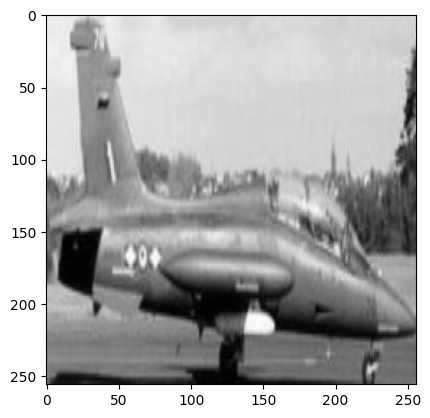

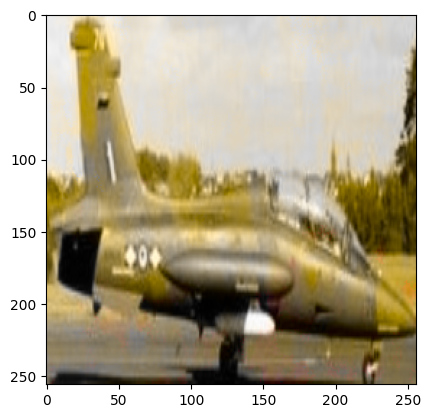

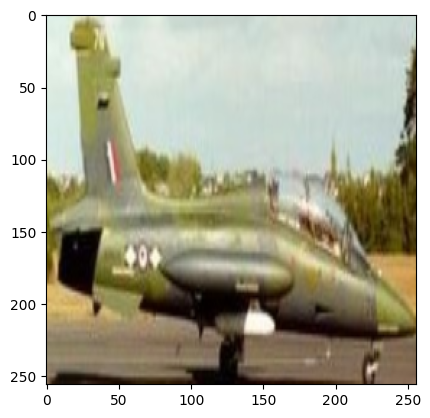

In [187]:
# display

from utils import *
net.eval()
with torch.no_grad():
    x, _ = next(iter(full_folder))
    x = x[0] # get first rgb image
    x_out = rgb_to_output(net, x, device)[0]
    x_lab = rgb2lab_skimage(x)
    x_lab[1] = 0
    x_lab[2] = 0
    plt.figure()
    plt.imshow(lab2rgb_skimage(x_lab).permute(1,2,0))
    plt.show()
    x_lab[1] = x_out[0]
    x_lab[2] = x_out[1]
    x_out_rgb = lab2rgb_skimage(x_lab).permute(1,2,0)
    plt.figure()
    plt.imshow(x_out_rgb)
    plt.show()
    plt.figure()
    plt.imshow(x.permute(1,2,0))
    plt.show()

In [191]:
net.load_state_dict(torch.load("models/trainbest.pth"))
net.eval()
sum_base = 0
sum_correct = 0
sum_total = 0
sum_confident = 0
with torch.no_grad():
    i = 0
    for img, _ in full_folder:
        batchsize, input_channels, img_size, _ = img.shape
        batch_lab = rgb2lab_batch(img, False).to(device)
        L = batch_lab[:,:1].to(device)
        result = net(L)[0]
        img_lab = rgb2lab_skimage(img[0])
        img = img.to(device)
        img_lab[1] = 0
        img_lab[2] = 0
        img_gray = lab2rgb_skimage(img_lab).unsqueeze(0).to(device)
        img_lab[1] = result[0]
        img_lab[2] = result[1]
        img_out_rgb = lab2rgb_skimage(img_lab).unsqueeze(0).to(device)
        confidence1, output_real = torch.max(vgg(img).data, 1)
        confidence2, output_gray = torch.max(vgg(img_gray).data, 1)
        confidence3, output_fake = torch.max(vgg(img_out_rgb).data, 1)
        i+=1
        sum_total+=1
        if output_real == output_gray: sum_base+=1
        if output_real == output_fake:
            sum_correct+=1
            if confidence3.item() >= confidence2.item():
                sum_confident+=1
accuracy = sum_correct/sum_total * 100
baseline = sum_base / sum_total * 100
confident= sum_confident / sum_correct * 100
print("Train Dataset")
print(f'Accuracy on grayscale images: {baseline}%')
print(f'Accuracy on fake colorized images from model: {accuracy}%')
print(f'Percentage of accurate fake where confidence is higher than grayscale: {confident}%')

sum_base = 0
sum_correct = 0
sum_total = 0
sum_confident = 0
with torch.no_grad():
    i = 0
    for img, _ in img_test_loader:
        batchsize, input_channels, img_size, _ = img.shape
        batch_lab = rgb2lab_batch(img, False).to(device)
        L = batch_lab[:,:1].to(device)
        result = net(L)[0]
        img_lab = rgb2lab_skimage(img[0])
        img = img.to(device)
        img_lab[1] = 0
        img_lab[2] = 0
        img_gray = lab2rgb_skimage(img_lab).unsqueeze(0).to(device)
        img_lab[1] = result[0]
        img_lab[2] = result[1]
        img_out_rgb = lab2rgb_skimage(img_lab).unsqueeze(0).to(device)
        confidence1, output_real = torch.max(vgg(img).data, 1)
        confidence2, output_gray = torch.max(vgg(img_gray).data, 1)
        confidence3, output_fake = torch.max(vgg(img_out_rgb).data, 1)
        i+=1
        sum_total+=1
        if output_real == output_gray: sum_base+=1
        if output_real == output_fake:
            sum_correct+=1
            if confidence3.item() >= confidence2.item():
                sum_confident+=1
accuracy = sum_correct/sum_total * 100
baseline = sum_base / sum_total * 100
confident= sum_confident / sum_correct * 100
print("Full Dataset")
print(f'Accuracy on grayscale images: {baseline}%')
print(f'Accuracy on fake colorized images from model: {accuracy}%')
print(f'Percentage of accurate fake where confidence is higher than grayscale: {confident}%')

Train Dataset
Accuracy on grayscale images: 71.42857142857143%
Accuracy on fake colorized images from model: 92.85714285714286%
Percentage of accurate fake where confidence is higher than grayscale: 69.23076923076923%
Full Dataset
Accuracy on grayscale images: 48.275862068965516%
Accuracy on fake colorized images from model: 50.0%
Percentage of accurate fake where confidence is higher than grayscale: 58.620689655172406%
